* Install package transformer to using the pre-trained bert model on the hugging face

In [38]:
!pip install transformers

* Using pytorch framework to construct Deep learning network based on the pre-trained open source model on Huggingface

In [1]:
import torch
from transformers import BertTokenizer
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from transformers import BertForSequenceClassification, AdamW


* First of all, we load the data in the training set then load it into the Dataframe in Pandas

In [3]:
PATH = '../train/train_df.csv'
data = pd.read_csv(PATH) 

* load the tokenizer in the pre-trained model in bert to split the sentence in the dataset
* set the maximum size of the tokenizer
* create lists to save split words, padding, attention musk


In [76]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
max_length = 128  
input_ids = []
attention_masks = []
labels = []

* To Train the model on GPU device just using torch.device("cuda"), my device is m1 chip macbook so it will be mps

In [73]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # This always results in MPS
device = torch.device("cpu")
device

device(type='cpu')

In [62]:
print(data)

       stars                                               text  label
0          5  My go to place in East Nashville!Three suggest...      2
1          2  Skip it! Not worth the $27.50. The cruise itse...      0
2          2  We came here for lunch with a coupon. In order...      0
3          5  I attended PMA's Risk Management Professional ...      2
4          4  Love the food at El Tumi, but it is truly fami...      2
...      ...                                                ...    ...
15995      5  Seriously the best breakfast I have had in a l...      2
15996      5  Martin and his staff were super friendly. He w...      2
15997      5  I'm pleased to say that I tried the Elm Cafe C...      2
15998      5  Best sandwiches in St.Louis! Could eat here ev...      2
15999      4  In New Orleans, it would be shameful not to dr...      2

[16000 rows x 3 columns]


* Create the DataLoader in the format of {text, label}
* And for each rows: tokenize the (text) using encoder in the tokenizer to make it tensor in the pytorch format
* And add the data to device to be calculated

In [77]:
for text, label in zip(data["text"], data["label"]):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors="pt"
    )
    input_ids.append(encoded_text["input_ids"])
    attention_masks.append(encoded_text["attention_mask"])
    labels.append(label)

input_ids_tensor = torch.cat(input_ids, dim=0).to(device)
attention_mask_tensor = torch.cat(attention_masks, dim=0).to(device)
labels_tensor = torch.tensor(labels).to(device)

# create the data loader
batch_size = 32
dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


* Using bert pre-train model to create a initial version of BERT model performing sentiment analysis
* Number of class is set to be three

In [78]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3).to(device)  

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

* Initial the optimizer with learning rate in 1e-5
* Criterion of Loss function is cross entropy function with class weight ( since during the process of creating the data set we find the number of each Label is class 2: 14031, class 1: 2241, class 0: 3728 respectively)
* Our aim is to let the model focus more on the class have fewer number. So the weight is about [5,4,1] for class 0, 1, 2

| class | number |
|-------|--------|
| 2     | 14031  |
| 0     | 3728   |
| 1     | 2241   |

In [79]:
optimizer = AdamW(model.parameters(), lr=1e-8)
class_weights = [4, 5, 1]
criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(class_weights)).to(device)

* Applying learning rate decay for training models
* Using StepLR in lr_scheduler. And first parameter is optimizer, the second one is learning rate decay 0.1 every 5 epoch

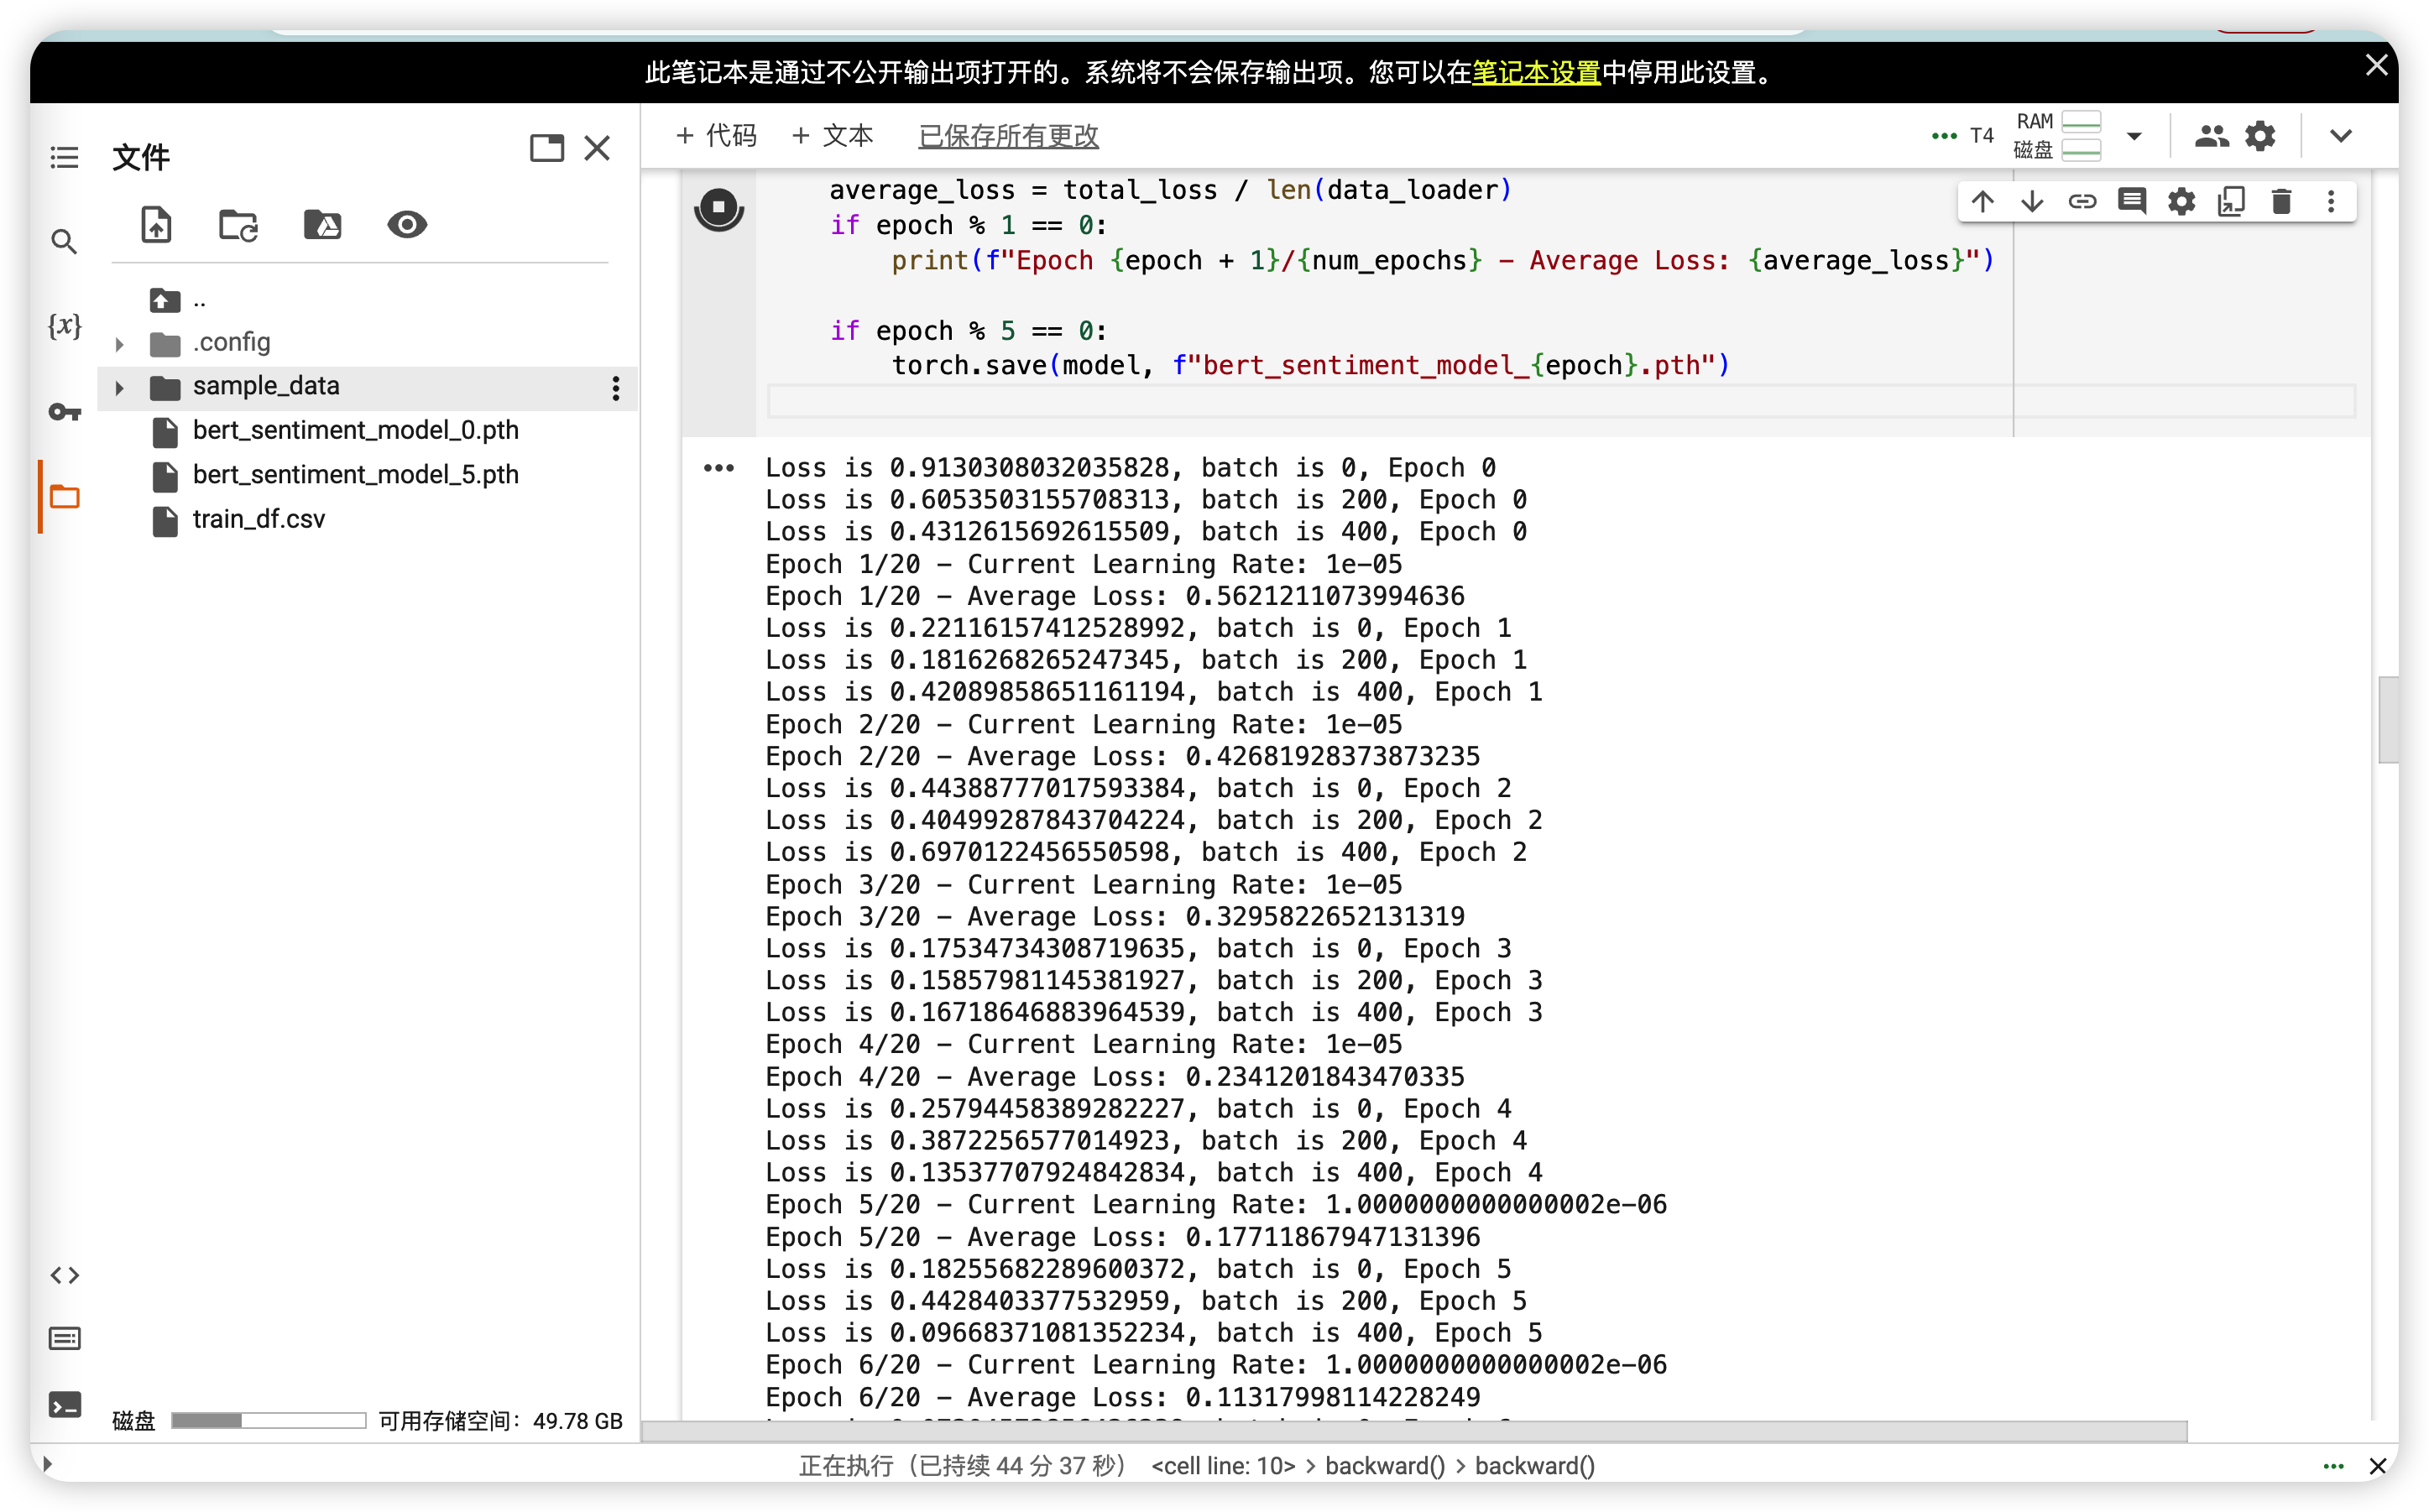

In [ ]:
from torch.optim.lr_scheduler import StepLR
# Initial StepLR 
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

model.train()
num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    # print current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1}/{num_epochs} - Current Learning Rate: {current_lr}")

    for index, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits.to(device)
        loss = criterion(logits, labels).to(device)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if index % 200 == 0:
            print(f"Loss is {loss}, batch is {index}, Epoch {epoch}")
    
    # adjust learning rate after each epoch 
    scheduler.step()
    
    average_loss = total_loss / len(data_loader)
    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs} - Average Loss: {average_loss}")
    
    if epoch % 5 == 0:
        torch.save(model, f"bert_sentiment_model_{epoch}.pth")


* I finished 10 epoch training using the free GPU resource on Colab and save the model parameter in pkl file.
* This to Load the file and performing the test part.
* But My device is m1 chip MacBook , so I need to load the cuda model in the cpu format to avoid the runtime error.

In [80]:
import torch
model_filename = "bert_sentiment_model_cpu.pth"
# model_filename = 'bert_sentiment_model_5.pth'
model = torch.load(model_filename, map_location={'cuda': 'cpu'})


* Performing the test part of model by loading test set
* load the data in the test data set and using tokenizer to do the data preprocess
* the max length of token must be keep the same as train set

In [82]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import torch
import numpy as np
test_data = pd.read_csv('../YELP/test/test_df.csv')  

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

max_length = 128  # 
input_ids = []
attention_masks = []
labels = []

for text, label in zip(test_data["text"], test_data["label"]):
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors="pt"
    )
    input_ids.append(encoded_text["input_ids"])
    attention_masks.append(encoded_text["attention_mask"])
    labels.append(label)

input_ids_tensor = torch.cat(input_ids, dim=0).to(device)
attention_mask_tensor = torch.cat(attention_masks, dim=0).to(device)
labels_tensor = torch.tensor(labels).to(device)

batch_size = 32
test_dataset = TensorDataset(input_ids_tensor, attention_mask_tensor, labels_tensor)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # shuffle=False to keep the test data in order




Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/fangzheng/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


* Test the model using fusion matrix combine with the accuracy to analyze the classification ability of our model

In [83]:
model.eval()
all_preds = []
true_labels = []

with torch.no_grad():
    for batch in test_data_loader:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        all_preds.extend(logits.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


pred_labels = np.argmax(all_preds, axis=1)
accuracy = accuracy_score(true_labels, pred_labels)
class_report = classification_report(true_labels, pred_labels)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.84825
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       758
           1       0.41      0.48      0.44       448
           2       0.94      0.92      0.93      2794

    accuracy                           0.85      4000
   macro avg       0.73      0.74      0.73      4000
weighted avg       0.86      0.85      0.85      4000



* Result analyze

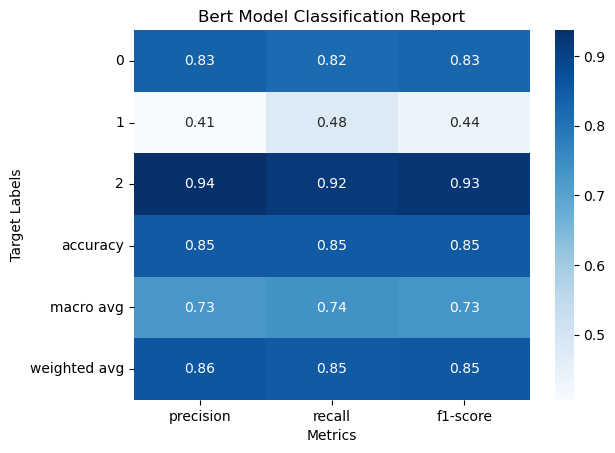

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

report_dict = classification_report(true_labels, pred_labels, output_dict=True)

sns.heatmap(pd.DataFrame(report_dict).iloc[:-1, :].T, annot=True, cmap="Blues")

plt.xlabel("Metrics")
plt.ylabel("Target Labels")
plt.title("Bert Model Classification Report")

plt.show()

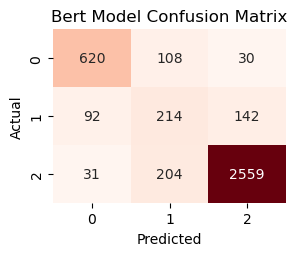

In [88]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(3, 2.25))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d', cbar=False)
plt.title('Bert Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


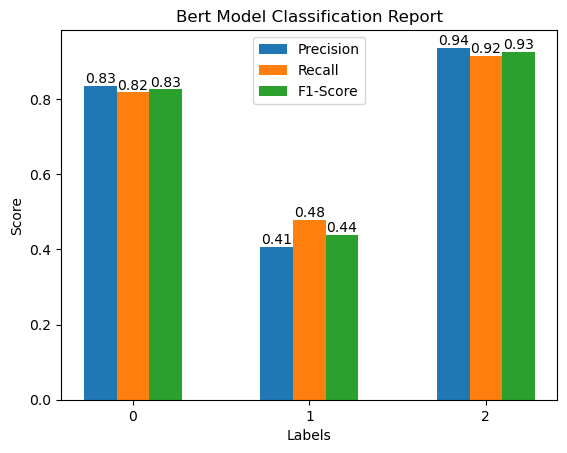

In [89]:
labels = [label for label in report_dict.keys() if label not in ('accuracy', 'macro avg', 'weighted avg')]
precision = [report_dict[label]['precision'] for label in labels]
recall = [report_dict[label]['recall'] for label in labels]
f1_score = [report_dict[label]['f1-score'] for label in labels]

x = range(len(labels))
width = 0.185

plt.bar(x, precision, width, label='Precision')
plt.bar([i + width for i in x], recall, width, label='Recall')
plt.bar([i + 2 * width for i in x], f1_score, width, label='F1-Score')
for i, val in enumerate(precision):
    plt.text(i, val, round(val, 2), ha='center', va='bottom')
for i, val in enumerate(recall):
    plt.text(i+width, val, round(val, 2), ha='center', va='bottom')
for i, val in enumerate(f1_score):
    plt.text(i+2*width, val, round(val, 2), ha='center', va='bottom')
plt.xlabel('Labels')
plt.ylabel('Score')
plt.title('Bert Model Classification Report')

plt.xticks([i + width for i in x], labels)
plt.legend(loc='upper center')

plt.show()


* Label 0, 1, 2 represent for negtive comment, neutral comment and positive comment respectively.
* Find from the above results model is not good at classifying the 1 label which has the less data.
* At the same time, perhaps a neutral comment is not so different from a positive, negtive comment in terms of emotion, but that doesn't mean that a neutral comment is a positive, negtive comment.

| class | number |
|-------|--------|
| 2     | 14031  |
| 0     | 3728   |
| 1     | 2241   |